## NLP Homework Task №3: Movie sentiment analysis
*Author: Solonin Maxim*

The task:

1. Choose and argue your measure of a test's accuracy.
2. Build data processing and classification pipeline; Please compare word-embeddings vs classical methods.
3. Tune  your model.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import LinearSVC
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import random
import gensim

In [2]:
train = pd.read_csv('train.tsv', sep = '\t')
test = pd.read_csv('test.tsv', sep = '\t')

### Exploratory data analysis 

In [3]:
print("The number of unique sentences is: {}".format(train.SentenceId.nunique()))
print("The number of Phrases is: {}".format(train.PhraseId.nunique()))

The number of unique sentences is: 8529
The number of Phrases is: 156060


In [4]:
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

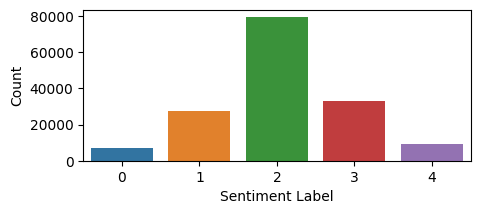

In [11]:
# Set up graph
fig, ax = plt.subplots(1, 1, dpi = 100, figsize = (5, 2))

# Get data
sentiment_labels = train['Sentiment'].value_counts().index
sentiment_count = train['Sentiment'].value_counts()

# Plot graph
sns.barplot(x = sentiment_labels, y = sentiment_count)

# Plot labels
ax.set_ylabel('Count')    
ax.set_xlabel('Sentiment Label')
plt.show()

The most simple analysis shows that we have 8529 review sentences divided into more than 156 thousands of phrases. Majority of reviews turn out to be "neutral". Our data demonstrates clear imbalance in classes.

I am going to use oversampling of minority classes in order to cope with sample imbalance.

In [4]:
#Using simple oversampling repeating the observations from minority classes
sent_2 = train[train['Sentiment']==2]
#we will copy class 0 11 times
sent_0 = train[train['Sentiment']==0]
#we will copy class 1 2 times
sent_1 = train[train['Sentiment']==1]
#we will copy class 3 2 times
sent_3 = train[train['Sentiment']==3]
#we will copy class 4 8 times
sent_4 = train[train['Sentiment']==4]

train_b = sent_2
for x in [sent_0,sent_1,sent_3,sent_4]:
    train_b = train_b.append([x]*int(len(sent_2)/len(x)))



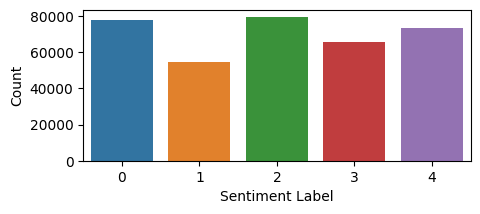

In [5]:
# Set up graph
fig, bx = plt.subplots(1, 1, dpi = 100, figsize = (5, 2))

# Get data
sentiment_labels_b = train_b['Sentiment'].value_counts().index
sentiment_count_b = train_b['Sentiment'].value_counts()

# Plot graph
sns.barplot(x = sentiment_labels_b, y = sentiment_count_b)

# Plot labels
bx.set_ylabel('Count')    
bx.set_xlabel('Sentiment Label')
plt.show()

Now, the classes are more or less balanced.

Now, I would suggest dividing the training set into train and validation ones, because test set does not have Sentiment column.

In [6]:
X = train_b.drop('Sentiment',axis = 1)
y = train_b['Sentiment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Classics  

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
training_features = vectorizer.fit_transform(X_train["Phrase"])    
test_features = vectorizer.transform(X_test["Phrase"])


In [9]:
# Building classification pipelines

pipeline2 = Pipeline([('vect', vectorizer),
                     ('clf', LogisticRegression(multi_class='ovr', solver='sag', random_state=42))])

pipeline3 = Pipeline([('vect', vectorizer),
                     ('clf', LinearSVC(multi_class='ovr', random_state=42))])


In [10]:
model_LR = pipeline2.fit(X_train['Phrase'],y_train)


In [11]:
model_SVC = pipeline3.fit(X_train['Phrase'],y_train)

In [12]:
print(classification_report(y_test,model_LR.predict(X_test['Phrase'])))
print(f1_score(y_test,model_LR.predict(X_test['Phrase']),average='weighted'))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87     23203
           1       0.70      0.44      0.54     16399
           2       0.65      0.73      0.69     23861
           3       0.66      0.50      0.57     19778
           4       0.78      0.90      0.83     22186

    accuracy                           0.73    105427
   macro avg       0.72      0.71      0.70    105427
weighted avg       0.72      0.73      0.71    105427

0.713809140682


In [13]:
print(classification_report(y_test,model_SVC.predict(X_test['Phrase'])))
print(f1_score(y_test,model_SVC.predict(X_test['Phrase']),average='weighted'))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     23203
           1       0.74      0.60      0.66     16399
           2       0.72      0.69      0.71     23861
           3       0.72      0.61      0.66     19778
           4       0.83      0.95      0.89     22186

    accuracy                           0.78    105427
   macro avg       0.77      0.77      0.77    105427
weighted avg       0.77      0.78      0.77    105427

0.774277554985


LinearSVC model performs a little bit better than Logistic regression. Random forest strangely was too slow even for google engine.

### Model tuning

Let's tune the best of two models - LinearSVC

In [16]:
parameters3 = {'clf__multi_class':['ovr','crammer_singer'],
    'clf__C': [0.01, 1, 100]
}

In [20]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline3, parameters3, cv=3,
                               n_jobs=-1, verbose=1,scoring='f1_weighted')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline3.steps])
    print("parameters:")
    pprint(parameters3)
    t0 = time()
    grid_search.fit(X_train['Phrase'], y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score for Linear SVC: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters3.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': [0.01, 1, 100], 'clf__multi_class': ['ovr', 'crammer_singer']}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/jet/var/python/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/jet/var/python/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/jet/var/python/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 747, in _queue_management_worker
    recursive_terminate(p)
  File "/jet/var/python/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/jet/var/python/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 53, in _recursive_terminate_without_psutil
    _recursive_terminate(process.pid)
  File "/jet/var/python/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 107, in _recursive_term

KeyboardInterrupt: 

### Embedding way

I decided to try word2vec, which analyses the words by their surroundings. I have chosen CBOW method, because it requires less computer power and more intuitive from human perspective - identifies the word, by surrounding, not vice versa.

In [18]:
w2v = gensim.models.Word2Vec(train['Phrase'], size = 200, window = 7, min_count = 40, sample = 0.001)

In [19]:
w2v.init_sims(replace=True)

In [20]:
def createFeatureVector(words, model, num_features):
    #initialize a 1D array with length as num of features of word2vec model chosen by us. 
    #Here it is 250.
    featVector = np.zeros((num_features,),dtype="float32")
    
    nWords = 0
    
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, as set is faster
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word and add it to the feature vector to get the total sum of feature vectors of the
    #entire review
    for word in words:
        if word in index2word_set: 
            nWords = nWords + 1.
            featVector = np.add(featVector,model[word])
            
    # Divide the result by the number of words to get the average of the feature vectors of 
    #all words in the review
    if(nWords != 0):
        featVector = np.divide(featVector,nWords)
    return featVector

#calculates the average of the feature vectors for each review using the word2vec values assigned for 
#each word
def avgFeatureVectors(sentences, model, num_features):
    overallFeatureVectors = []
    for sentence in tqdm(sentences):
        overallFeatureVectors.append(createFeatureVector(sentence, model, num_features)) 
    return overallFeatureVectors

train_vect = avgFeatureVectors(X_train['Phrase'], w2v, 200)
test_vect = avgFeatureVectors(X_test['Phrase'], w2v, 200)

100%|██████████| 105427/105427 [00:29<00:00, 3615.37it/s]


In [24]:
#split into train and validation sets.
target = y_train.values
X_tr,X_val,y_tr,y_val=train_test_split(train_vect,target,test_size=0.2,stratify=target)

#Model RF
model_rf = RandomForestClassifier(random_state=1, n_estimators=200, verbose=1, n_jobs=-1, oob_score=True)
model_rf.fit(X_tr, y_tr)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=1,
                       warm_start=False)

In [ ]:
print(classification_report(y_val,model_rf.predict(X_val)))

### Results

It turned out that random forest using word embedding approach (CBOW) demonstrates better results for sentiment identification.
Thus, we are using it to predict sentiments on test  data.

In [30]:
res_test = avgFeatureVectors(test['Phrase'], w2v, 200)
results = model_rf.predict(res_test)

100%|██████████| 66292/66292 [00:13<00:00, 4978.01it/s]
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.8s finished


In [32]:
results = pd.DataFrame(results)
results.to_csv('Submission.csv')

So, I saved the result, compared word embedding with classical approach and understood that in this particular case embedding suits better.